# Agent with tool-calling using smolagents

**Retrieval-Augmented-Generation (RAG)** is `using an LLM to answer a user query, but basing the answer on information retrieved from a knowledge base`.

## Install required dependencies

In [ ]:
!pip install smolagents datasets langchain sentence-transformers faiss-cpu duckduckgo-search openai langchain-community --upgrade -q

In [2]:
from huggingface_hub import notebook_login

notebook_login()

## 1. Multimodal + Web-browsing assistant

  - An agent that browses the web and is able to generate images.

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Generate me a photo of f-35 fighter Jet destoring Nazi tanks                                                    │
│                                                                                                                 │
╰─ InferenceClientModel - Qwen/Qwen2.5-72B-Instruct ──────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  image = image_generator(prompt="A high-res, photorealistic image of an F-35 fighter jet destroying Nazi tanks")  
  final_answer(image)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7A5D761D9D90>

[Step 1: Duration 6.73 seconds| Input tokens: 2,120 | Output tokens: 71]

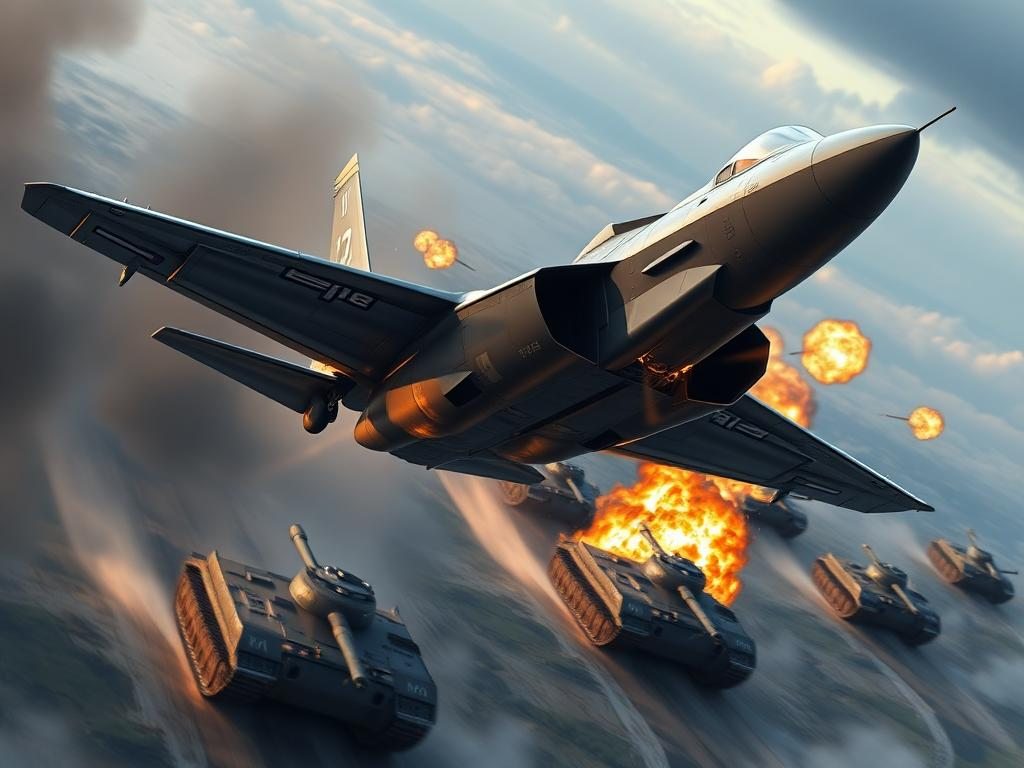

In [40]:
from smolagents import load_tool, CodeAgent, InferenceClientModel, DuckDuckGoSearchTool

# Import tool from Hub
image_generation_tool = load_tool("m-ric/text-to-image", trust_remote_code=True)


search_tool = DuckDuckGoSearchTool()

model = InferenceClientModel("Qwen/Qwen2.5-72B-Instruct")
# Initialize the agent with both tools
agent = CodeAgent(tools=[image_generation_tool, search_tool], model=model)

# Run it!
result = agent.run(
    "Generate me a photo of f-35 fighter Jet destoring Nazi tanks",
)
result

## 2. RAG with Iterative query refinement & Source selection

### load a knowledge base on which we want to perform RAG

In [4]:
import datasets

knowledge_base = datasets.load_dataset("m-ric/huggingface_doc", split="train")

README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

huggingface_doc.csv:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2647 [00:00<?, ? examples/s]

### Prepare the knowledge base by processing the dataset and storing it into a vector database

In [5]:
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

source_docs = [
    Document(page_content=doc["text"], metadata={"source": doc["source"].split("/")[1]}) for doc in knowledge_base
]

docs_processed = RecursiveCharacterTextSplitter(chunk_size=500).split_documents(source_docs)[:1000]

embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-small")
vectordb = FAISS.from_documents(documents=docs_processed, embedding=embedding_model)

<ipython-input-5-89693acdcfba>:12: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-small")


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Sources of our documentation pages

In [6]:
all_sources = list(set([doc.metadata["source"] for doc in docs_processed]))
print(all_sources)

['hub-docs', 'evaluate', 'deep-rl-class', 'peft', 'blog', 'datasets-server', 'datasets', 'optimum', 'transformers', 'pytorch-image-models', 'diffusers', 'hf-endpoints-documentation', 'course', 'gradio']


### let’s build a RetrieverTool to retrieve information from the knowledge base.

In [33]:
import json
from smolagents import Tool
from langchain_core.vectorstores import VectorStore

class RetrieverTool(Tool):
    name = "retriever"
    description = (
        "Retrieves some documents from the knowledge base that have the closest embeddings to the input query."
    )
    inputs = {
        "query": {
            "type": "string",
            "description": "The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.",
        },
        "source": {
            "type": "string",
            "description": "",
            "nullable": True
        },
        "number_of_documents": {
            "type": "string",
            "description": "the number of documents to retrieve. Stay under 10 to avoid drowning in docs",
            "nullable": True
        },
    }
    output_type = "string"

    def __init__(self, vectordb: VectorStore, all_sources: list, **kwargs):
        super().__init__(**kwargs)
        self.vectordb = vectordb
        self.inputs["source"]["description"] = (
            f"The source of the documents to search, as a str representation of a list. "
            f"Possible values in the list are: {all_sources}. If this argument is not provided, all sources will be searched."
        )

    def forward(self, query: str, source: str = None, number_of_documents=7) -> str:
        assert isinstance(query, str), "Your search query must be a string"
        number_of_documents = int(number_of_documents)

        if source:
            # parse string or list
            if isinstance(source, str) and "[" not in source:
                source = [source]
            source = json.loads(str(source).replace("'", '"'))

        docs = self.vectordb.similarity_search(
            query,
            filter=( {"source": source} if source else None ),
            k=number_of_documents,
        )

        if not docs:
            return "No documents found with this filtering. Try removing the source filter."
        return "Retrieved documents:\n\n" + "\n===Document===\n".join(
            doc.page_content for doc in docs
        )


In [38]:
# # Share our Retriever tool to Hub
# share_to_hub = True

# if share_to_hub:
#     from huggingface_hub import login
#     from retriever import RetrieverTool

#     login("your_token")

#     tool = RetrieverTool(vectordb, all_sources)

#     tool.push_to_hub(repo_id="m-ric/retriever-tool")

#     # Loading the tool
#     from smolagents import load_tool

#     retriever_tool = load_tool("m-ric/retriever-tool", vectordb=vectordb, all_sources=all_sources)

### Run the agent

In [37]:
from smolagents import InferenceClientModel, ToolCallingAgent

model = InferenceClientModel("Qwen/Qwen2.5-72B-Instruct")

retriever_tool = RetrieverTool(
    vectordb=vectordb,
    all_sources=all_sources)

agent = ToolCallingAgent(
    tools=[retriever_tool],
    model=model,
    max_steps=4,           # if you need to limit the number of thought–tool loops
    verbosity_level=0      # replaces `verbose=0`
)


In [39]:
agent_output = agent.run(
    "Please show me a MedVLM model parameter script"
)

print("Final output:")
print(agent_output)

Final output:
```bash
python run_medvlm.py \
  --model_name_or_path path/to/medvlm \
  --dataset_name your_dataset_name \
  --output_dir medvlm-finetuned \
  --do_train \
  --do_eval \
  --max_steps 1000 \
  --evaluation_strategy steps \
  --eval_steps 100 \
  --learning_rate 5e-5 \
  --load_best_model_at_end \
  --metric_for_best_model "eval_f1" \
  --push_to_hub \
  --push_to_hub_model_id medvlm-finetuned
```


## 3. Debug Python code

In [43]:
from smolagents import CodeAgent

agent = CodeAgent(tools=[], model=InferenceClientModel("Qwen/Qwen2.5-72B-Instruct"))

code = """
numbers=[0, 1, 2]

for i in range(4):
    print(numbers(i))
"""

final_answer = agent.run(
    "I have some code that creates a bug: please debug it, then run it to make sure it works and return the final code",
    additional_args=dict(code=code),
)

In [13]:
print(final_answer)

numbers=[0, 1, 2]

for i in range(len(numbers)):
    print(numbers[i])
